# Comparing Random vs Non Random data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(12,5)})
%load_ext autoreload
%autoreload 2

In [2]:
import re
# from tqdm import tqdm
from tqdm.notebook import trange, tqdm

In [83]:
import sys
import os
sys.path.append(os.path.abspath('../modules'))
from lnds import longest_non_decreasing_subsequence as lnds
from hard_rules import denoised_fraction, version_serializtion
from lots import longest_sequence, plot_intervals

In [4]:
data = pd.read_parquet("../Data/random_10k.parquet")

In [5]:
data = data[data["maid"]=='7']

## Filtering
1. Non houses 
2. Cookies with mixed constant 
3. Cookies which are assigned to a house which they do not apepar in

In [6]:
data = data[~data['is_hh']]

In [7]:
unique_values_per_cookie = data.groupby(["hh_id", "iiqid"])[["timestamp", "brand", "model", "os", "browser", "advertisedbrowser"]].nunique()

In [8]:
unique_values_per_cookie["sum"] = unique_values_per_cookie.iloc[:,1:].sum(axis=1)

In [9]:
equal_5 = unique_values_per_cookie[unique_values_per_cookie["sum"]==5]
more_than_5 = unique_values_per_cookie[unique_values_per_cookie["sum"]>5]

In [10]:
mixed_iiqids = more_than_5.index.get_level_values(level=1).to_list()

In [11]:
data = data[~data['iiqid'].isin(mixed_iiqids)]

In [12]:
misplaced_series = ~data.groupby('iiqid')['is_house_ip_or_source_ip'].any()
misplaced_iiqids = misplaced_series[misplaced_series].index.values

In [13]:
data = data[~data['iiqid'].isin(misplaced_iiqids)]

## Creating relevant tables
- Random pairs
- Cookies time data
- Cookies version noise data

In [14]:
const = ['hh_id',"brand", "model", "os", "browser"]

In [15]:
def has_multiple_ua(house):
    user_agents = house[const].drop_duplicates()
    return len(user_agents) >= 2

In [16]:
filtered = data.groupby('hh_id', observed=True).filter(has_multiple_ua)

In [17]:
filtered_grouped_by = filtered.groupby(const, observed=True)
filtered_grouped = filtered_grouped_by.agg({'iiqid': ['nunique', pd.Series.mode]})

In [18]:
filtered_grouped.columns = ['nunique','iiqid']
filtered_grouped = filtered_grouped[filtered_grouped['nunique'] == 1].drop('nunique', axis=1)

In [19]:
grouped = filtered_grouped.iloc[:,0].drop_duplicates()

In [20]:
grouped = grouped.groupby(level=0, observed=True).filter(lambda g: g.nunique() > 1)

In [21]:
two_from_each_houe = grouped.groupby(observed=True, level=0, group_keys=False).apply(lambda g: g.sample(2))

In [22]:
trial_data = two_from_each_houe.reset_index()#.drop('hh_id', axis=1).reset_index()

In [23]:
trial_pairs = trial_data.groupby('hh_id')['iiqid'].agg(['min', 'max'])
trial_pairs.columns = ['first','second']

In [24]:
cookie_time = data.groupby('iiqid')['time'].agg(['min', 'max'])

In [25]:
cookie_time['interval'] = (cookie_time['max'] - cookie_time['min']).apply(lambda t: t.days)

In [26]:
noises = data.groupby('iiqid').apply(denoised_fraction)

In [27]:
noises = noises.rename('noise')

### A single pair

- Time interval first
- Time interval second
- Time between end first and start second(maybe after remove outliers)
- Time interval we looked at (can check options)
- Number of points min
- Number of points max
- UA version error
- Overlap errors that we calculate

In [28]:
random_cookie_1 = np.random.choice(data['iiqid'].unique())
random_cookie_2 = np.random.choice(data['iiqid'].unique())

In [29]:
size1 = len(data[data['iiqid']==random_cookie_1])
size2 = len(data[data['iiqid']==random_cookie_2])

In [30]:
single_row = pd.DataFrame({'id1': [random_cookie_1], 'id2': [random_cookie_2], 
              'min_size': min(size1, size2), 'max_size':max(size1, size2)})

In [31]:
single_row = single_row.merge(cookie_time, left_on='id1', right_index=True)
single_row = single_row.merge(cookie_time, left_on='id2', right_index=True, 
                              suffixes=('_id1', '_id2'))

In [32]:
single_row = single_row.merge(noises, left_on='id1', right_index=True)
single_row = single_row.merge(noises, left_on='id2', right_index=True, 
                              suffixes=('_id1', '_id2'))

In [33]:
single_row

,id1,id2,min_size,max_size,min_id1,max_id1,interval_id1,min_id2,max_id2,interval_id2,noise_id1,noise_id2
0,2ZhxMqNQP9,KpCd9TagdY,4,4,2023-02-18 08:59:44.468,2023-02-24 00:29:32.526,5,2022-12-16 20:41:15.485,2023-01-24 20:40:41.563,38,1.0,1.0


### Random Data

In [34]:
noise_of_pairs = {'merge_noise': [], 'size_0': [], 'size_1': [], 'first' :[], 'second': []}

for house in tqdm(trial_pairs.index):
    iiqid_0, iiqid_1 = trial_pairs.loc[house].values
    pair_data = filtered[(filtered['hh_id']==house) 
                     & ((filtered['iiqid']==iiqid_0) 
                        | (filtered['iiqid']==iiqid_1))].copy()
    pair_data.sort_values(by='time', inplace=True)
    serialize_id = {iiqid_0: 0, iiqid_1: 1}
    
    s, inds = lnds(pair_data['iiqid'].apply(lambda x: serialize_id[x]).values)
    not_inds = [i for i in range(len(pair_data)) if i not in inds]
    
    noise_of_pairs['merge_noise'].append(1 - len(s) / len(pair_data))
    noise_of_pairs['size_0'].append(sum(pair_data['iiqid']==iiqid_0))
    noise_of_pairs['size_1'].append(sum(pair_data['iiqid']==iiqid_1))
    noise_of_pairs['first'].append(iiqid_0)
    noise_of_pairs['second'].append(iiqid_1)
noise_of_pairs_df = pd.DataFrame(noise_of_pairs)

  0%|          | 0/1330 [00:00<?, ?it/s]

In [35]:
random_trial_data = noise_of_pairs_df.merge(cookie_time, left_on='first', right_index=True)
random_trial_data = random_trial_data.merge(cookie_time, left_on='second', right_index=True, 
                              suffixes=('_0', '_1'))

In [36]:
random_trial_data = random_trial_data.merge(noises, left_on='first', right_index=True)
random_trial_data = random_trial_data.merge(noises, left_on='second', right_index=True, 
                              suffixes=('_0', '_1'))

In [37]:
random_trial_data['min_size'] = random_trial_data[['size_0','size_1']].min(axis=1)
random_trial_data['max_size'] = random_trial_data[['size_0','size_1']].max(axis=1)

In [38]:
random_trial_data = random_trial_data.rename(columns={'min_0': 'start_0', 'max_0': 'end_0',
                                  'min_1': 'start_1', 'max_1': 'end_1',
                                  'noise_0': 'vers_clean_0', 'noise_1': 'vers_clean_1'})

In [39]:
random_trial_data['min_interval'] = random_trial_data[['interval_0', 'interval_1']].min(axis=1)
random_trial_data['max_interval'] = random_trial_data[['interval_0', 'interval_1']].max(axis=1)

random_trial_data['min_vers_clean'] = random_trial_data[['vers_clean_0', 'vers_clean_1']].min(axis=1)
random_trial_data['max_vers_clean'] = random_trial_data[['vers_clean_0', 'vers_clean_1']].max(axis=1)

In [40]:
random_trial_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
merge_noise,1330.0,0.129633,0.140677,0.000000,0.012987,0.072297,0.211285,0.5
size_0,1330.0,41.087970,79.100762,1.000000,2.000000,11.000000,47.000000,875.0
size_1,1330.0,42.530827,80.782969,1.000000,2.000000,12.000000,46.000000,1148.0
interval_0,1330.0,35.066165,33.107597,0.000000,0.000000,30.000000,68.000000,88.0
interval_1,1330.0,35.957143,33.273346,0.000000,0.000000,31.000000,71.000000,88.0
vers_clean_0,1330.0,0.998556,0.012621,0.666667,1.000000,1.000000,1.000000,1.0
vers_clean_1,1330.0,0.998316,0.013584,0.666667,1.000000,1.000000,1.000000,1.0
min_size,1330.0,12.751880,25.386673,1.000000,1.000000,3.000000,12.000000,229.0
max_size,1330.0,70.866917,102.222442,1.000000,11.000000,35.000000,90.000000,1148.0
min_interval,1330.0,17.830827,25.597700,0.000000,0.000000,0.000000,32.000000,87.0


<AxesSubplot: >

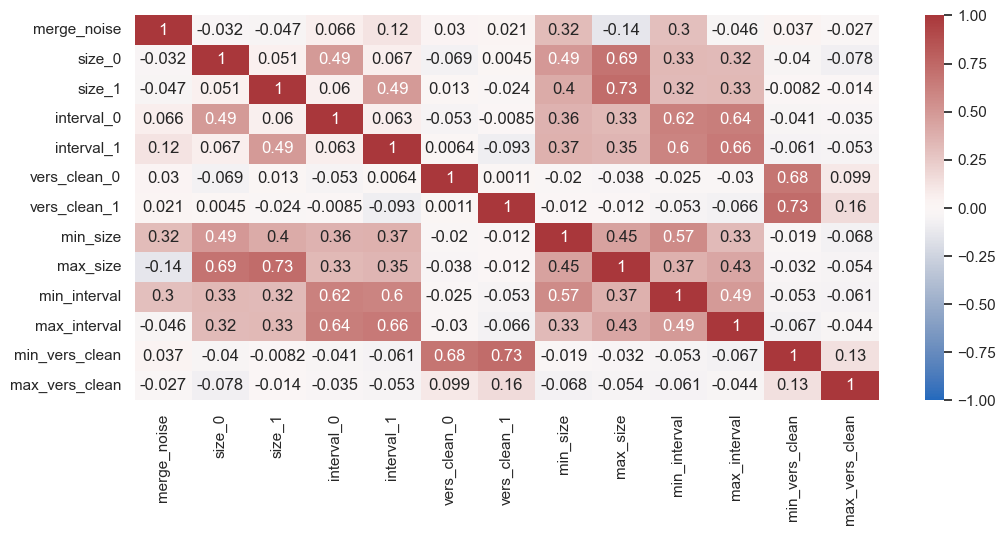

In [41]:
sns.heatmap(data=random_trial_data.corr(numeric_only=True), annot=True, vmin=-1, vmax=1, cmap='vlag')

In [42]:
# mins = random_trial_data[features].min()
# maxs = random_trial_data[features].max()

In [43]:
# random_trial_data.loc[(random_trial_data[features] >= thresholds).all(axis=1), 'merge_noise'].mean()

In [44]:
# matrix = []
# for s in range(1, 30):
#     row = []
#     for i in range(14):
#         row.append(random_trial_data.loc[(random_trial_data[features] >= [s, i, 0.5]).all(axis=1), 
#                                          'merge_noise'].mean())
#     matrix.append(row)

From all the pairs which 
1. Both cookies have more instances than some threshold
2. Both cookies are lived more than somethreshold
3. Both cookies have version consistency more than some threshold  

What fraction have the the merging noise is less than some threshold?

In [45]:
features = ['min_size', 'min_interval', 'min_vers_clean']
target = 'merge_noise'

In [244]:
# features
thresholds = [3, 7, 0.5]
noise_thresh = 0.02

In [47]:
total_above_thresh = random_trial_data.loc[(random_trial_data[features] >= thresholds).all(axis=1)]
good_aobve_thresh = total_above_thresh[total_above_thresh['merge_noise'] < noise_thresh]
print(len(good_aobve_thresh)/len(total_above_thresh))

0.3211538461538462


In [48]:
matrix = []
for s in range(1, 30):
    row = []
    for i in range(14):
        total_above_thresh = random_trial_data.loc[(random_trial_data[features] >= [s, i, 0.5]).all(axis=1)]
        good_aobve_thresh = total_above_thresh[total_above_thresh['merge_noise'] < noise_thresh]
        row.append(len(good_aobve_thresh)/len(total_above_thresh))
    matrix.append(row)

<AxesSubplot: >

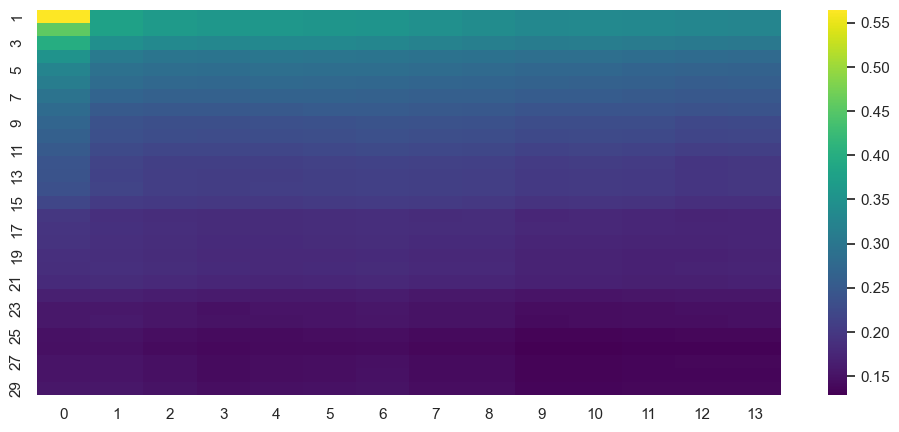

In [49]:
sns.heatmap(data=pd.DataFrame(matrix, columns=range(14), index=range(1,30)), 
            cmap='viridis')

## Non-Random Data

In [496]:
more_than_one_cooke = data.groupby(const, observed=True).filter(lambda g: g['iiqid'].nunique() > 1)

In [503]:
def pick_two_random(group):
    return np.random.choice(group.unique(), size=2, replace=False)

pairs_series = more_than_one_cooke.groupby(const, observed=True)['iiqid'].agg(pick_two_random)

In [504]:
brothers_paris = pd.DataFrame.from_dict(
        dict(zip(range(len(pairs_series)), pairs_series.values))).\
        transpose()
brothers_paris.columns = ['first','second']

In [505]:
i = 0
iiqid_0, iiqid_1 = trial_pairs.iloc[i].values
print(iiqid_0, iiqid_1)

IUjkGRKgxd gUlQWbXrL9


In [507]:
noise_of_pairs2 = {'merge_noise': [], 'size_0': [], 'size_1': [], 'first' :[], 'second': []}

for i in tqdm(brothers_paris.index):
    iiqid_0, iiqid_1 = brothers_paris.iloc[i].values
    pair_data = more_than_one_cooke[((more_than_one_cooke['iiqid']==iiqid_0) 
                        | (more_than_one_cooke['iiqid']==iiqid_1))].copy()
    pair_data.sort_values(by='time', inplace=True)
    serialize_id = {iiqid_0: 0, iiqid_1: 1}
    
    s, inds = lnds(pair_data['iiqid'].apply(lambda x: serialize_id[x]).values)
    not_inds = [i for i in range(len(pair_data)) if i not in inds]
    
    noise_of_pairs2['merge_noise'].append(1 - len(s) / len(pair_data))
    noise_of_pairs2['size_0'].append(sum(pair_data['iiqid']==iiqid_0))
    noise_of_pairs2['size_1'].append(sum(pair_data['iiqid']==iiqid_1))
    noise_of_pairs2['first'].append(iiqid_0)
    noise_of_pairs2['second'].append(iiqid_1)
noise_of_pairs_df2 = pd.DataFrame(noise_of_pairs2)

  0%|          | 0/2627 [00:00<?, ?it/s]

In [508]:
random_trial_data2 = noise_of_pairs_df2.merge(cookie_time, left_on='first', right_index=True)
random_trial_data2 = random_trial_data2.merge(cookie_time, left_on='second', right_index=True, 
                              suffixes=('_0', '_1'))

In [509]:
random_trial_data2 = random_trial_data2.merge(noises, left_on='first', right_index=True)
random_trial_data2 = random_trial_data2.merge(noises, left_on='second', right_index=True, 
                              suffixes=('_0', '_1'))

In [510]:
random_trial_data2['min_size'] = random_trial_data2[['size_0','size_1']].min(axis=1)
random_trial_data2['max_size'] = random_trial_data2[['size_0','size_1']].max(axis=1)

In [511]:
random_trial_data2 = random_trial_data2.rename(columns={'min_0': 'start_0', 'max_0': 'end_0',
                                  'min_1': 'start_1', 'max_1': 'end_1',
                                  'noise_0': 'vers_clean_0', 'noise_1': 'vers_clean_1'})

In [512]:
random_trial_data2['min_interval'] = random_trial_data2[['interval_0', 'interval_1']].min(axis=1)
random_trial_data2['max_interval'] = random_trial_data2[['interval_0', 'interval_1']].max(axis=1)

random_trial_data2['min_vers_clean'] = random_trial_data2[['vers_clean_0', 'vers_clean_1']].min(axis=1)
random_trial_data2['max_vers_clean'] = random_trial_data2[['vers_clean_0', 'vers_clean_1']].max(axis=1)

In [513]:
random_trial_data2.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
merge_noise,2627.0,0.142912,0.151900,0.000000,0.008183,0.088889,0.25,0.5
size_0,2627.0,37.561096,94.802988,1.000000,2.000000,10.000000,37.00,2974.0
size_1,2627.0,35.126380,70.458233,1.000000,2.000000,10.000000,36.00,1042.0
interval_0,2627.0,28.394366,31.294947,0.000000,0.000000,15.000000,56.00,88.0
interval_1,2627.0,28.227255,30.956947,0.000000,0.000000,15.000000,55.00,88.0
vers_clean_0,2627.0,0.997939,0.016765,0.500000,1.000000,1.000000,1.00,1.0
vers_clean_1,2627.0,0.998030,0.020983,0.538462,1.000000,1.000000,1.00,1.0
min_size,2627.0,12.804720,28.359264,1.000000,1.000000,4.000000,13.00,590.0
max_size,2627.0,59.882756,109.736474,1.000000,8.000000,26.000000,73.00,2974.0
min_interval,2627.0,15.379520,23.755792,0.000000,0.000000,0.000000,25.00,88.0


In [514]:
# random_trial_data2.corr(numeric_only=True)['merge_noise'][1:].plot.bar()

<AxesSubplot: >

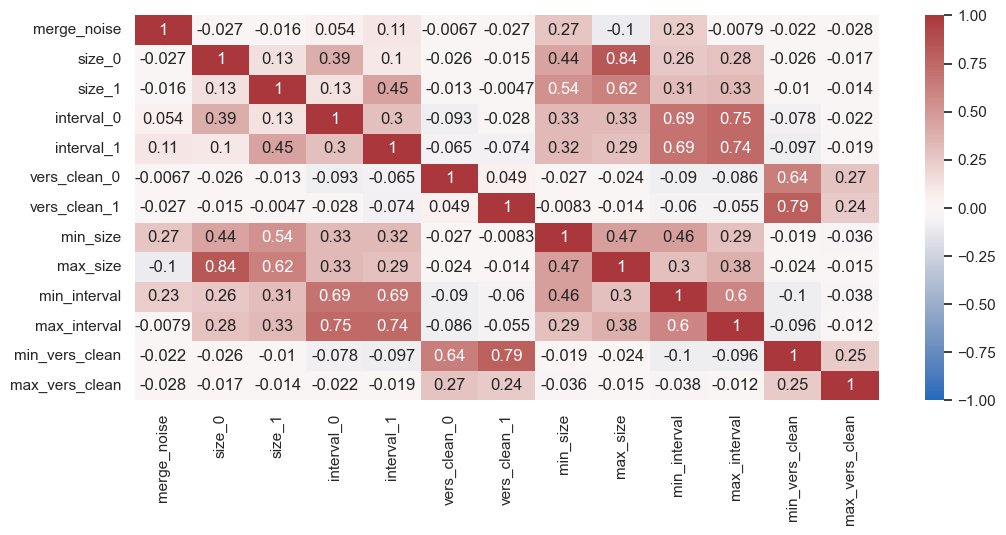

In [515]:
sns.heatmap(data=random_trial_data2.corr(numeric_only=True), annot=True, vmin=-1, vmax=1, cmap='vlag')

In [516]:
features = ['min_size', 'min_interval', 'min_vers_clean']
target = 'merge_noise'

In [517]:
matrix2 = []
for s in range(1, 30):
    row = []
    for i in range(14):
        total_above_thresh = random_trial_data2.loc[(random_trial_data2[features] >= [s, i, 0.5]).all(axis=1)]
        good_aobve_thresh = total_above_thresh[total_above_thresh['merge_noise'] < noise_thresh]
        row.append(len(good_aobve_thresh)/len(total_above_thresh))
    matrix2.append(row)

<AxesSubplot: >

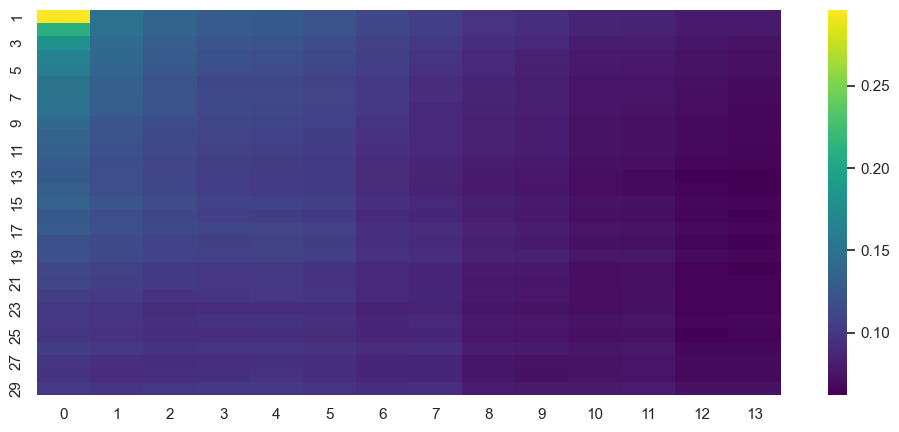

In [518]:
sns.heatmap(data=pd.DataFrame(matrix2, columns=range(14), index=range(1,30)), 
            cmap='viridis')

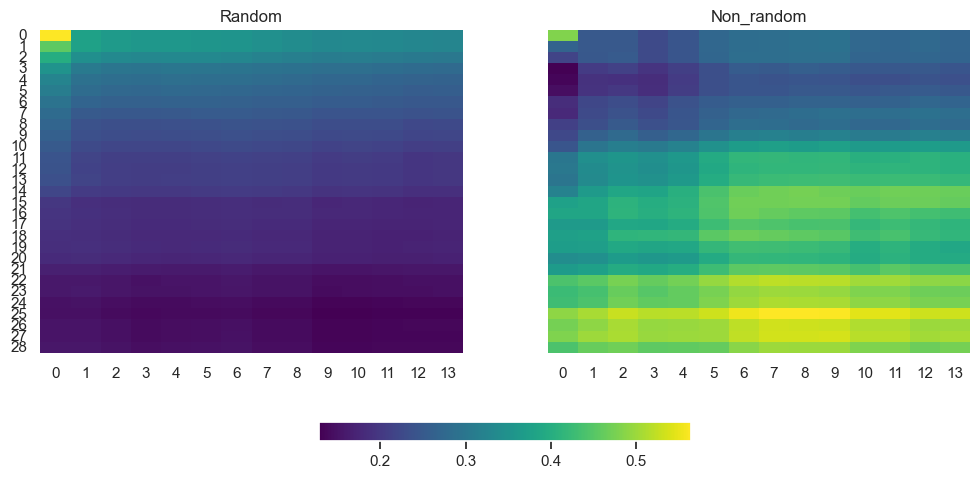

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

heatmap1 = sns.heatmap(matrix, cmap='viridis', ax=ax[0], cbar=False)
ax[0].set_title('Random')

heatmap2 = sns.heatmap(matrix2, cmap='viridis', ax=ax[1], cbar=False)
ax[1].set_title('Non_random')

# Add a shared colorbar to the plot
mappable = heatmap1.get_children()[0]
plt.colorbar(mappable, ax = ax,orientation = 'horizontal', shrink=0.4)

In [67]:
matrix_part = [m[:10] for m in matrix[:10]]
matrix2_part = [m[:10] for m in matrix2[:10]]

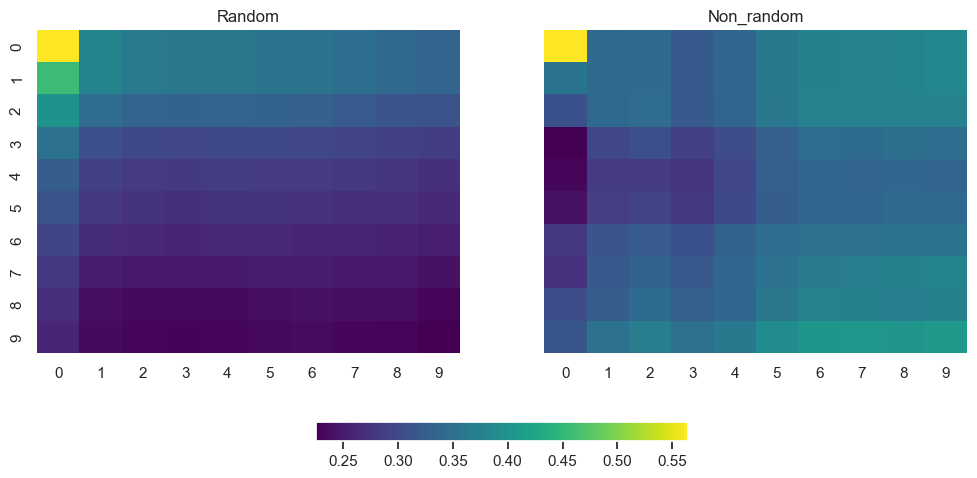

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

heatmap1 = sns.heatmap(matrix_part, cmap='viridis', ax=ax[0], cbar=False)
ax[0].set_title('Random')

heatmap2 = sns.heatmap(matrix2_part, cmap='viridis', ax=ax[1], cbar=False)
ax[1].set_title('Non_random')

# Add a shared colorbar to the plot
mappable = heatmap1.get_children()[0]
plt.colorbar(mappable, ax = ax,orientation = 'horizontal', shrink=0.4)

In [69]:
s = 20
i = 14
len(random_trial_data.loc[(random_trial_data[features] >= [s, i, 0.5]).all(axis=1)])

215

In [70]:
matrix_test = []
for s in range(1, 30):
    row = []
    for i in range(14):
        total_above_thresh = random_trial_data2.loc[(random_trial_data2[features] >= [s, i, 0.5]).all(axis=1)]
        good_aobve_thresh = total_above_thresh[total_above_thresh['merge_noise'] < noise_thresh]
        row.append(len(total_above_thresh))
    matrix_test.append(row)

In [71]:
min(min(matrix_test))

414

Text(0.5, 1.0, 'Non-Random')

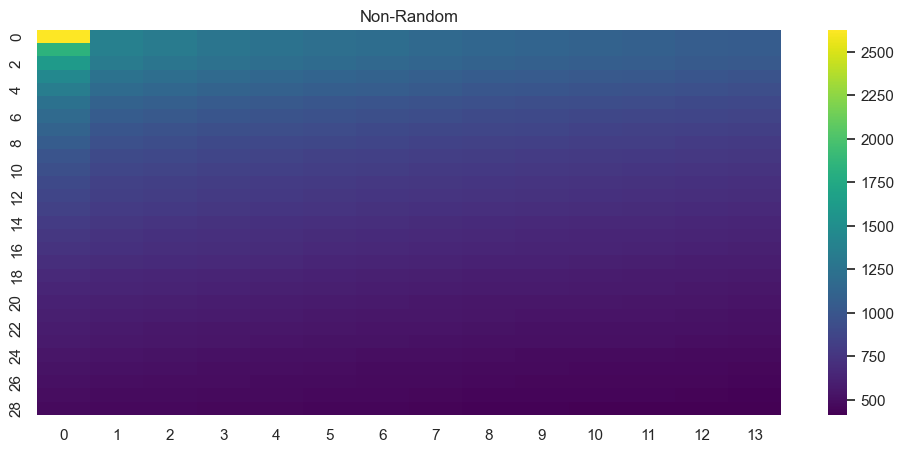

In [72]:
sns.heatmap(matrix_test, cmap='viridis')
plt.title("Non-Random")

## GridSearch

In [73]:
def good_cookies_above_thresh(df, min_interval, min_size, min_vers_clean, merge_noise):
    total_above_thresh = df.loc[(df[features] >= [min_size, min_interval, min_vers_clean]).all(axis=1)]
    good_aobve_thresh = total_above_thresh[total_above_thresh['merge_noise'] < merge_noise]
    return len(good_aobve_thresh)/len(total_above_thresh)

In [74]:
# Define the ranges of parameter values to sample from
param_ranges = {
    'min_interval': np.arange(0, 14),
    'min_size': np.arange(1, 10),
    'min_vers_clean': np.linspace(0.5, 1, 10),
    'merge_noise': np.linspace(0, 0.2, 11)
}

# Set the number of random samples to generate
num_samples = 5000

# Initialize variables to keep track of the best parameter values and the largest difference
best_diff_params = None
best_ratio_params = None
largest_difference = None
largest_ratio = None

# Loop over all random samples of parameter values
for i in tqdm(range(num_samples)):
    # Sample random values for each parameter within the specified ranges
    param_values = {
        param_name: np.random.choice(param_range) for param_name, param_range in param_ranges.items()
    }
    
    # Apply the function to both dataframes with the current parameter values
    result1 = good_cookies_above_thresh(random_trial_data, **param_values)
    result2 = good_cookies_above_thresh(random_trial_data2, **param_values)
    
    # Compute the difference between the results
    difference = abs(result2 - result1)
    if result2 > 0:
        ratio = 1 - result1/result2
    else:
        ratio = 0
    
    # Check if the current parameter values give a larger difference than the previous best
    if largest_difference is None or difference > largest_difference:
        largest_difference = difference
        best_diff_params = param_values

    if largest_ratio is None or ratio > largest_ratio:
        largest_ratio = ratio
        best_ratio_params = param_values

# Print the best parameter values and the largest difference
print("Best difference parameters:", {k: round(v, 3) for k,v in best_diff_params.items()})
print("Largest difference:", largest_difference)
print("Best ratio parameters:", {k: round(v, 3) for k,v in best_ratio_params.items()})
print("Largest ratio:", largest_ratio)

  0%|          | 0/5000 [00:00<?, ?it/s]

Best difference parameters: {'min_interval': 12, 'min_size': 9, 'min_vers_clean': 1.0, 'merge_noise': 0.02}
Largest difference: 0.5879853366945915
Best ratio parameters: {'min_interval': 12, 'min_size': 8, 'min_vers_clean': 0.556, 'merge_noise': 0.02}
Largest ratio: 0.9660930997097191


In [75]:
result_diff = {k: round(v, 3) for k,v in best_diff_params.items()}
result_diff['random'] = good_cookies_above_thresh(random_trial_data, **best_diff_params)
result_diff['non-random'] = good_cookies_above_thresh(random_trial_data2, **best_diff_params)
pd.DataFrame(result_diff, index=['best'])

,min_interval,min_size,min_vers_clean,merge_noise,random,non-random
best,12,9,1.0,0.02,0.022556,0.610542


In [76]:
result_diff = {k: round(v, 3) for k,v in best_ratio_params.items()}
result_diff['random'] = good_cookies_above_thresh(random_trial_data, **best_ratio_params)
result_diff['non-random'] = good_cookies_above_thresh(random_trial_data2, **best_ratio_params)
pd.DataFrame(result_diff, index=['best'])

,min_interval,min_size,min_vers_clean,merge_noise,random,non-random
best,12,8,0.556,0.02,0.01983,0.584838


In [77]:
# Define the ranges of parameter values to sample from
param_ranges = {
    'min_interval': np.arange(0, 14),
    'min_size': np.arange(1, 10),
    'min_vers_clean': np.linspace(0.5, 1, 10),
    'merge_noise': np.linspace(0, 0.2, 11)
}

# Set the number of random samples to generate
num_samples = 5000

# Initialize an empty dataframe to store the results
results_df = pd.DataFrame(columns=list(param_ranges.keys()) + ['random', 'non-random', 'difference', 'ratio'])

# Loop over all random samples of parameter values
for i in tqdm(range(num_samples)):
    # Sample random values for each parameter within the specified ranges
    param_values = {
        param_name: np.random.choice(param_range) for param_name, param_range in param_ranges.items()
    }
    
    # Apply the function to both dataframes with the current parameter values
    result1 = good_cookies_above_thresh(random_trial_data, **param_values)
    result2 = good_cookies_above_thresh(random_trial_data2, **param_values)
    
    # Compute the difference between the results
    difference = abs(result2 - result1)
    if result2 > 0:
        ratio = 1 - result1/result2
    else:
        ratio = 0.
    
    # Create a new dataframe with the current parameter values and the resulting difference
    row_df = pd.DataFrame({**param_values, 'random': result1, 'non-random': result2,
                           'difference': difference, 'ratio': ratio}, index=[0])
    
    # Concatenate the new dataframe to the results dataframe
    results_df = pd.concat([results_df, row_df], ignore_index=True)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [78]:
results_df['min_interval'] = results_df['min_interval'].astype('int')
results_df['min_size'] = results_df['min_size'].astype('int')

In [79]:
results_df.sort_values(by='ratio', ascending=False).head(10)

,min_interval,min_size,min_vers_clean,merge_noise,random,non-random,difference,ratio
3537,13,8,0.722222,0.02,0.020000,0.582725,0.562725,0.965678
4558,13,8,0.722222,0.02,0.020000,0.582725,0.562725,0.965678
1123,13,8,0.944444,0.02,0.020408,0.586035,0.565627,0.965176
3587,13,8,0.944444,0.02,0.020408,0.586035,0.565627,0.965176
4852,12,9,0.555556,0.02,0.020896,0.590512,0.569616,0.964615
3111,12,9,0.777778,0.02,0.020896,0.590226,0.569330,0.964597
4084,12,9,0.611111,0.02,0.020896,0.590000,0.569104,0.964584
4645,13,9,0.555556,0.02,0.021021,0.588903,0.567882,0.964305
4567,13,9,0.611111,0.02,0.021021,0.588384,0.567363,0.964273
879,13,9,0.722222,0.02,0.021021,0.588384,0.567363,0.964273


<AxesSubplot: >

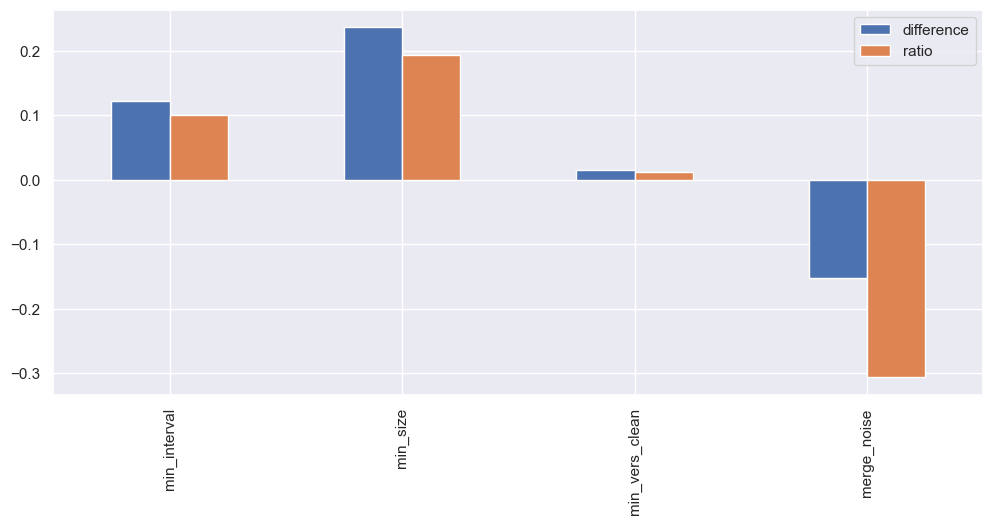

In [80]:
results_df.corr()[['difference', 'ratio']][:4].plot.bar()

## Restrict by longest living cookie

### LOTS

In [81]:
df = cookie_time.head(15).reset_index().sort_values(by='min')

In [84]:
longest_sequence(cookie_time.sample(15).reset_index(), name_str='iiqid', start_str='min', end_str='max')

['dVVZScWAgf', 'KCROCMLW2W']

In [85]:
shots = cookie_time[(5 < cookie_time['interval']) & (cookie_time['interval'] < 20)].reset_index()

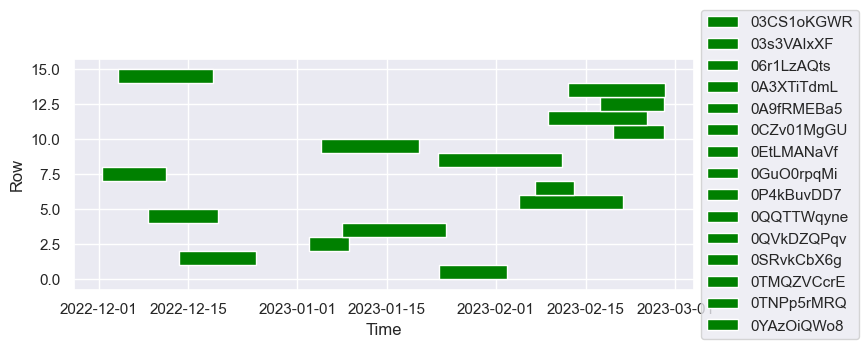

In [197]:
# df = cookie_time.sample(15).reset_index()
df = shots.head(15)
chosen_ids = longest_sequence(df, name_str='iiqid', start_str='min', end_str='max')
plot_intervals(df, name_str='iiqid', start_str='min', end_str='max', color='green')

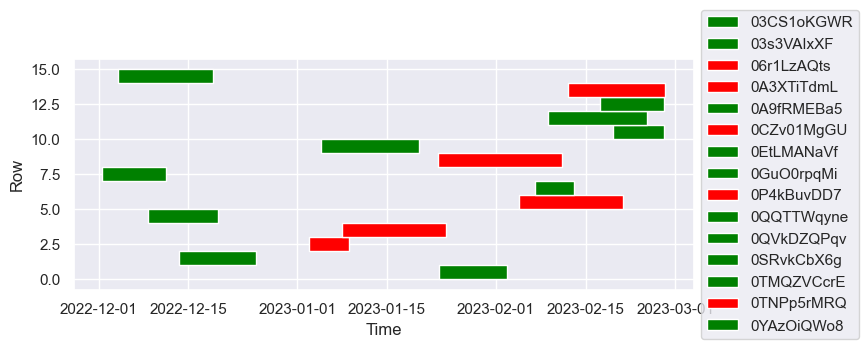

In [86]:
# df = cookie_time.sample(15).reset_index()
df = shots.head(15)
chosen_ids = longest_sequence(df, name_str='iiqid', start_str='min', end_str='max')
plot_intervals(df, name_str='iiqid', start_str='min', end_str='max', color='green', highlight_ids=chosen_ids, highlight_color='red')

### Filtering

In [519]:
const = ['hh_id',"brand", "model", "os", "browser"]

In [520]:
cookies_data = cookie_time.reset_index().merge(data[const+['iiqid']], on='iiqid', how='left')

In [521]:
longest_cookie_per_home = cookies_data.groupby('hh_id').apply(lambda h: h.loc[h['interval'].idxmax(), 'iiqid'])

In [522]:
longest_cookie_per_home.name = 'iiqid'

In [523]:
longest_cookie_per_home_data = pd.merge(longest_cookie_per_home.reset_index(), cookies_data, 
                                        on=['hh_id', 'iiqid'], how='inner')
longest_cookie_per_home_data = longest_cookie_per_home_data.drop_duplicates()

In [524]:
cookie_vs_longest = cookies_data.merge(longest_cookie_per_home_data, on='hh_id', suffixes=[None, '_longest'])

In [525]:
filtered_cookies = cookie_vs_longest[(((cookie_vs_longest['min'] < cookie_vs_longest['min_longest'])
                                       & (cookie_vs_longest['max'] > cookie_vs_longest['min_longest']))
                                      | ((cookie_vs_longest['min'] > cookie_vs_longest['min_longest'])
                                         & (cookie_vs_longest['min'] < cookie_vs_longest['max_longest'])))]

In [526]:
filtered_cookies = filtered_cookies.drop_duplicates()

In [527]:
filtered_data = data[data['iiqid'].isin(filtered_cookies['iiqid'].values.tolist())]

#### Random

In [528]:
def has_multiple_ua(house):
    user_agents = house[const].drop_duplicates()
    return len(user_agents) >= 2

In [529]:
filtered = filtered_data.groupby('hh_id', observed=True).filter(has_multiple_ua)

In [530]:
filtered_grouped_by = filtered.groupby(const, observed=True)
filtered_grouped = filtered_grouped_by.agg({'iiqid': ['nunique', pd.Series.mode]})

In [531]:
filtered_grouped.columns = ['nunique','iiqid']
filtered_grouped = filtered_grouped[filtered_grouped['nunique'] == 1].drop('nunique', axis=1)

In [532]:
grouped = filtered_grouped.iloc[:,0].drop_duplicates()

In [533]:
grouped = grouped.groupby(level=0, observed=True).filter(lambda g: g.nunique() > 1)

In [534]:
two_from_each_houe = grouped.groupby(observed=True, level=0, group_keys=False).apply(lambda g: g.sample(2))

In [535]:
trial_data = two_from_each_houe.reset_index()#.drop('hh_id', axis=1).reset_index()

In [536]:
trial_pairs = trial_data.groupby('hh_id')['iiqid'].agg(['min', 'max'])
trial_pairs.columns = ['first','second']

In [537]:
noise_of_pairs = {'merge_noise': [], 'size_0': [], 'size_1': [], 'time_diff': [], 'first' : [], 'second': []}

for house in tqdm(trial_pairs.index):
    iiqid_0, iiqid_1 = trial_pairs.loc[house].values
    pair_data = filtered[(filtered['hh_id']==house) 
                     & ((filtered['iiqid']==iiqid_0) 
                        | (filtered['iiqid']==iiqid_1))].copy()
    pair_data.sort_values(by='time', inplace=True)
    iiqid_0_start, iiqid_1_start = pair_data.groupby('iiqid')['time'].agg('min').values
    pair_time_diff = abs(iiqid_0_start - iiqid_1_start)
    serialize_id = {iiqid_0: 0, iiqid_1: 1}
    
    s, inds = lnds(pair_data['iiqid'].apply(lambda x: serialize_id[x]).values)
    not_inds = [i for i in range(len(pair_data)) if i not in inds]
    
    noise_of_pairs['merge_noise'].append(1 - len(s) / len(pair_data))
    noise_of_pairs['size_0'].append(sum(pair_data['iiqid']==iiqid_0))
    noise_of_pairs['size_1'].append(sum(pair_data['iiqid']==iiqid_1))
    noise_of_pairs['time_diff'].append(pair_time_diff)
    noise_of_pairs['first'].append(iiqid_0)
    noise_of_pairs['second'].append(iiqid_1)
noise_of_pairs_df = pd.DataFrame(noise_of_pairs)

  0%|          | 0/886 [00:00<?, ?it/s]

In [538]:
random_trial_data = noise_of_pairs_df.merge(cookie_time, left_on='first', right_index=True)
random_trial_data = random_trial_data.merge(cookie_time, left_on='second', right_index=True, 
                              suffixes=('_0', '_1'))

In [539]:
random_trial_data = random_trial_data.merge(noises, left_on='first', right_index=True)
random_trial_data = random_trial_data.merge(noises, left_on='second', right_index=True, 
                              suffixes=('_0', '_1'))

In [540]:
random_trial_data['min_size'] = random_trial_data[['size_0','size_1']].min(axis=1)
random_trial_data['max_size'] = random_trial_data[['size_0','size_1']].max(axis=1)

In [541]:
random_trial_data.head(1)

,merge_noise,size_0,size_1,time_diff,first,second,min_0,max_0,interval_0,min_1,max_1,interval_1,noise_0,noise_1,min_size,max_size
0,0.0,77,6,27 days 09:33:45.099000,IUjkGRKgxd,gUlQWbXrL9,2022-12-02 09:48:10.154,2022-12-10 18:00:06.486,8,2022-12-29 19:21:55.253,2023-02-25 15:19:25.288,57,1.0,1.0,6,77


In [542]:
random_trial_data = random_trial_data.rename(columns={'min_0': 'start_0', 'max_0': 'end_0',
                                  'min_1': 'start_1', 'max_1': 'end_1',
                                  'noise_0': 'vers_clean_0', 'noise_1': 'vers_clean_1'})

In [543]:
random_trial_data['min_interval'] = random_trial_data[['interval_0', 'interval_1']].min(axis=1)
random_trial_data['max_interval'] = random_trial_data[['interval_0', 'interval_1']].max(axis=1)

random_trial_data['min_vers_clean'] = random_trial_data[['vers_clean_0', 'vers_clean_1']].min(axis=1)
random_trial_data['max_vers_clean'] = random_trial_data[['vers_clean_0', 'vers_clean_1']].max(axis=1)

In [544]:
random_trial_data['days_diff'] = random_trial_data.time_diff.apply(lambda t: t.days)

In [545]:
random_trial_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
merge_noise,886.0,0.130987,0.134723,0.0,0.016334,0.083333,0.216582,0.5
size_0,886.0,34.822799,64.791043,1.0,3.0,12.0,38.75,625.0
size_1,886.0,37.027088,66.946031,1.0,2.25,11.0,39.0,528.0
time_diff,886,26 days 17:35:15.242899548,21 days 18:38:39.593477743,0 days 00:26:34.866000,7 days 22:02:05.160750,21 days 02:33:25.607500,40 days 11:10:27.335750,86 days 10:15:40.361000
interval_0,886.0,32.30474,30.016412,0.0,0.0,28.0,59.0,87.0
interval_1,886.0,32.155756,30.688236,0.0,0.0,24.5,61.0,87.0
vers_clean_0,886.0,0.998058,0.015672,0.666667,1.0,1.0,1.0,1.0
vers_clean_1,886.0,0.998391,0.012402,0.8,1.0,1.0,1.0,1.0
min_size,886.0,10.520316,20.755971,1.0,1.0,3.0,12.0,382.0
max_size,886.0,61.329571,83.420762,1.0,11.0,30.0,78.0,625.0


<AxesSubplot: >

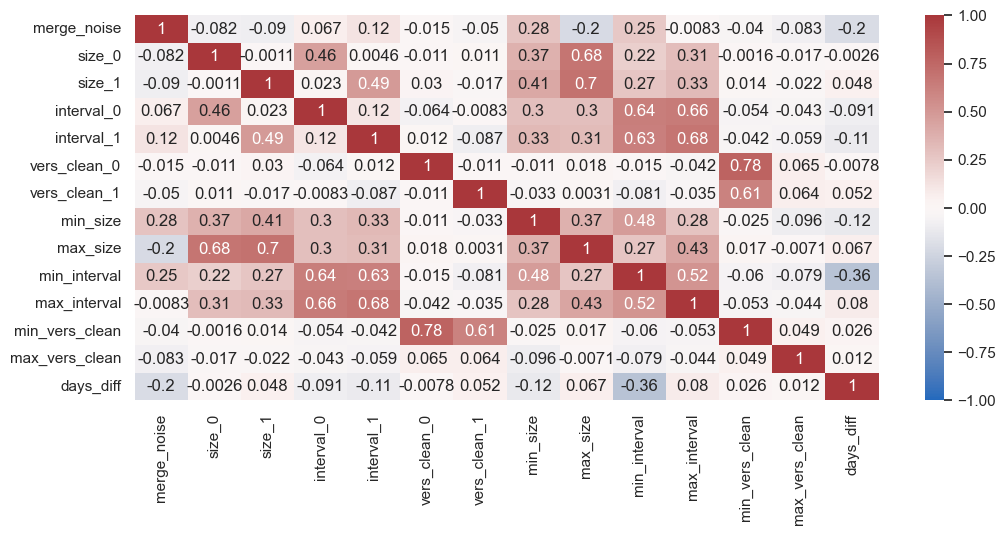

In [546]:
sns.heatmap(data=random_trial_data.corr(numeric_only=True), annot=True, vmin=-1, vmax=1, cmap='vlag')

From all the pairs which 
1. Both cookies have more instances than some threshold
2. Both cookies are lived more than somethreshold
3. Both cookies have version consistency more than some threshold  

What fraction have the the merging noise is less than some threshold?

In [547]:
features = ['min_size', 'min_interval', 'min_vers_clean']
target = 'merge_noise'

In [548]:
matrix = []
for s in range(1, 30):
    row = []
    for i in range(14):
        total_above_thresh = random_trial_data.loc[(random_trial_data[features] >= [s, i, 0.5]).all(axis=1)]
        good_aobve_thresh = total_above_thresh[total_above_thresh['merge_noise'] < noise_thresh]
        row.append(len(good_aobve_thresh)/len(total_above_thresh))
    matrix.append(row)

<AxesSubplot: >

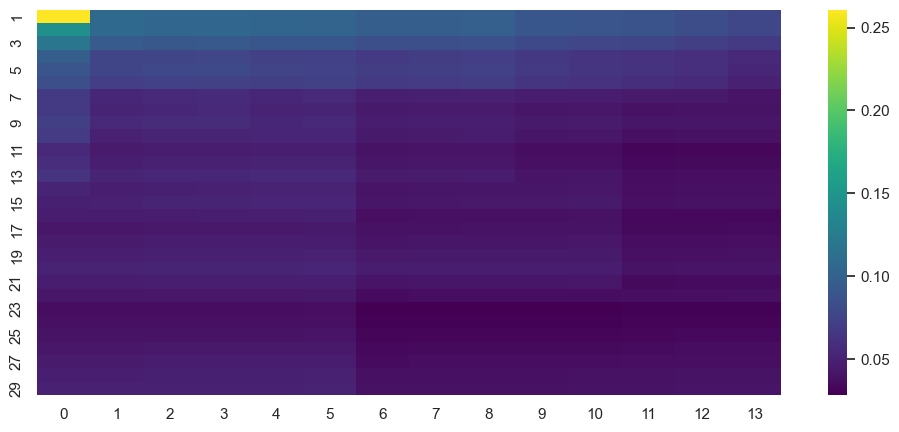

In [549]:
sns.heatmap(data=pd.DataFrame(matrix, columns=range(14), index=range(1,30)), 
            cmap='viridis')

#### Non-Random

In [550]:
more_than_one_cooke = filtered_data.groupby(const, observed=True).filter(lambda g: g['iiqid'].nunique() > 1)

In [551]:
def pick_two_random(group):
    return np.random.choice(group.unique(), size=2, replace=False)

pairs_series = more_than_one_cooke.groupby(const, observed=True)['iiqid'].agg(pick_two_random)

In [552]:
brothers_pairs = pd.DataFrame.from_dict(
        dict(zip(range(len(pairs_series)), pairs_series.values))).\
        transpose()
brothers_pairs.columns = ['first','second']

In [553]:
i = 3
iiqid_0, iiqid_1 = brothers_pairs.iloc[i].values
pair_data = more_than_one_cooke[((more_than_one_cooke['iiqid']==iiqid_0) 
                    | (more_than_one_cooke['iiqid']==iiqid_1))].copy()
pair_data.sort_values(by='time', inplace=True)
iiqid_0, iiqid_1
# iiqid_0_start, iiqid_1_start = pair_data.groupby('iiqid')['time'].agg('min').values
# print(iiqid_0_start, iiqid_1_start)
# pair_time_diff = abs(iiqid_0_start - iiqid_1_start)

('hYVQGjvJGM', 'JvxMvUw8UX')

In [554]:
noise_of_pairs2 = {'merge_noise': [], 'size_0': [], 'size_1': [], 'time_diff': [], 'first' : [], 'second': []}

for i in tqdm(brothers_pairs.index):
    iiqid_0, iiqid_1 = brothers_pairs.iloc[i].values
    pair_data = more_than_one_cooke[((more_than_one_cooke['iiqid']==iiqid_0) 
                        | (more_than_one_cooke['iiqid']==iiqid_1))].copy()
    pair_data.sort_values(by='time', inplace=True)
    iiqid_0_start, iiqid_1_start = pair_data.groupby('iiqid')['time'].agg('min').values
    pair_time_diff = abs(iiqid_0_start - iiqid_1_start)
    serialize_id = {iiqid_0: 0, iiqid_1: 1}
    
    s, inds = lnds(pair_data['iiqid'].apply(lambda x: serialize_id[x]).values)
    not_inds = [i for i in range(len(pair_data)) if i not in inds]
    
    noise_of_pairs2['merge_noise'].append(1 - len(s) / len(pair_data))
    noise_of_pairs2['size_0'].append(sum(pair_data['iiqid']==iiqid_0))
    noise_of_pairs2['size_1'].append(sum(pair_data['iiqid']==iiqid_1))
    noise_of_pairs2['time_diff'].append(pair_time_diff)    
    noise_of_pairs2['first'].append(iiqid_0)
    noise_of_pairs2['second'].append(iiqid_1)
noise_of_pairs_df2 = pd.DataFrame(noise_of_pairs2)

  0%|          | 0/1734 [00:00<?, ?it/s]

In [555]:
random_trial_data2 = noise_of_pairs_df2.merge(cookie_time, left_on='first', right_index=True)
random_trial_data2 = random_trial_data2.merge(cookie_time, left_on='second', right_index=True, 
                              suffixes=('_0', '_1'))

In [556]:
random_trial_data2 = random_trial_data2.merge(noises, left_on='first', right_index=True)
random_trial_data2 = random_trial_data2.merge(noises, left_on='second', right_index=True, 
                              suffixes=('_0', '_1'))

In [557]:
random_trial_data2['min_size'] = random_trial_data2[['size_0','size_1']].min(axis=1)
random_trial_data2['max_size'] = random_trial_data2[['size_0','size_1']].max(axis=1)

In [558]:
random_trial_data2 = random_trial_data2.rename(columns={'min_0': 'start_0', 'max_0': 'end_0',
                                  'min_1': 'start_1', 'max_1': 'end_1',
                                  'noise_0': 'vers_clean_0', 'noise_1': 'vers_clean_1'})

In [559]:
random_trial_data2['min_interval'] = random_trial_data2[['interval_0', 'interval_1']].min(axis=1)
random_trial_data2['max_interval'] = random_trial_data2[['interval_0', 'interval_1']].max(axis=1)

random_trial_data2['min_vers_clean'] = random_trial_data2[['vers_clean_0', 'vers_clean_1']].min(axis=1)
random_trial_data2['max_vers_clean'] = random_trial_data2[['vers_clean_0', 'vers_clean_1']].max(axis=1)

In [560]:
random_trial_data2['days_diff'] = random_trial_data2.time_diff.apply(lambda t: t.days)

In [561]:
random_trial_data2.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
merge_noise,1734.0,0.145904,0.151572,0.0,0.0,0.098315,0.25,0.5
size_0,1734.0,28.192042,57.385029,1.0,2.0,9.0,29.0,1171.0
size_1,1734.0,28.806228,57.571115,1.0,2.0,9.0,29.0,1008.0
time_diff,1734,22 days 23:53:12.725805651,21 days 07:13:55.338478051,0 days 00:00:00,5 days 02:43:41.567500,16 days 23:06:13.277000,35 days 09:45:39.842500,86 days 05:35:33.944000
interval_0,1734.0,24.512687,28.235912,0.0,0.0,12.0,46.0,88.0
interval_1,1734.0,24.700115,28.105564,0.0,0.0,13.0,46.0,87.0
vers_clean_0,1734.0,0.998318,0.016942,0.6,1.0,1.0,1.0,1.0
vers_clean_1,1734.0,0.998197,0.019098,0.5,1.0,1.0,1.0,1.0
min_size,1734.0,10.777393,20.431639,1.0,1.0,3.0,11.0,221.0
max_size,1734.0,46.220877,74.577001,1.0,7.0,20.5,56.75,1171.0


In [562]:
# random_trial_data2.corr(numeric_only=True)['merge_noise'][1:].plot.bar()

<AxesSubplot: >

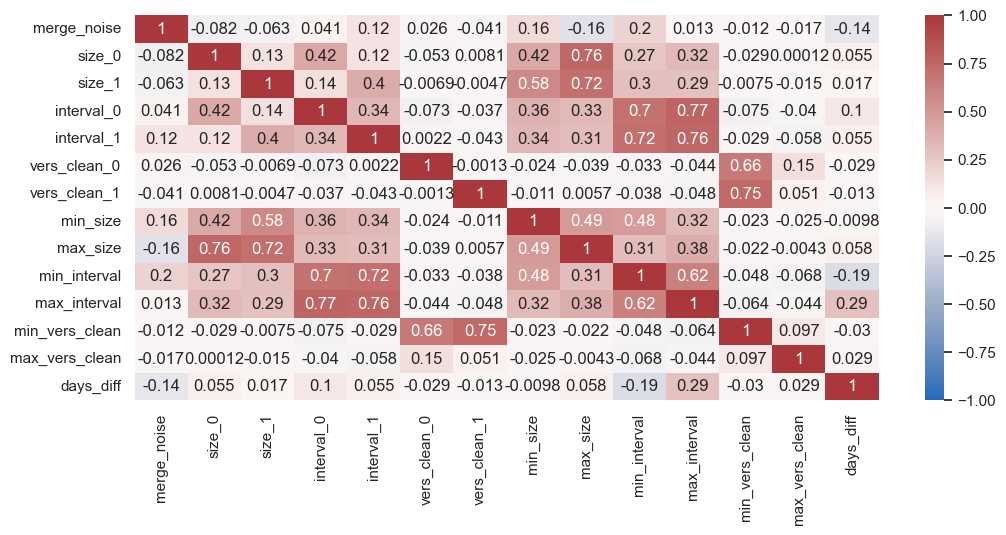

In [563]:
sns.heatmap(data=random_trial_data2.corr(numeric_only=True), annot=True, vmin=-1, vmax=1, cmap='vlag')

In [564]:
features = ['min_size', 'min_interval', 'min_vers_clean']
target = 'merge_noise'

In [565]:
matrix2 = []
for s in range(1, 30):
    row = []
    for i in range(14):
        total_above_thresh = random_trial_data2.loc[(random_trial_data2[features] >= [s, i, 0.5]).all(axis=1)]
        good_aobve_thresh = total_above_thresh[total_above_thresh['merge_noise'] < noise_thresh]
        row.append(len(good_aobve_thresh)/len(total_above_thresh))
    matrix2.append(row)

<AxesSubplot: >

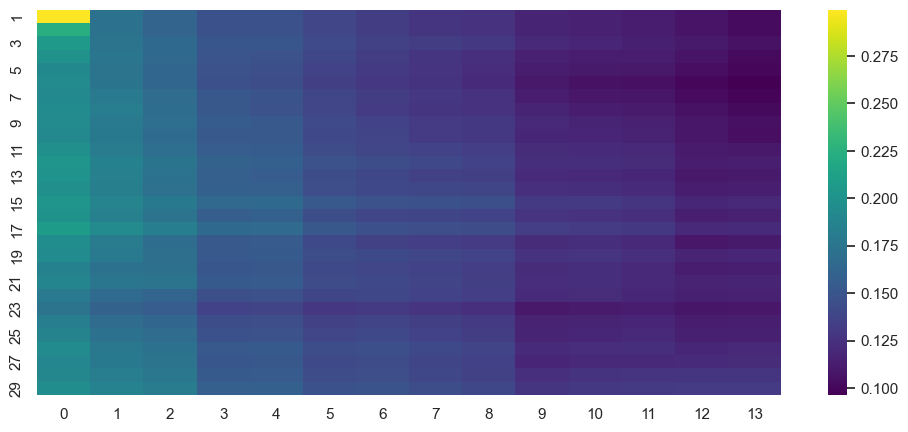

In [566]:
sns.heatmap(data=pd.DataFrame(matrix2, columns=range(14), index=range(1,30)), 
            cmap='viridis')

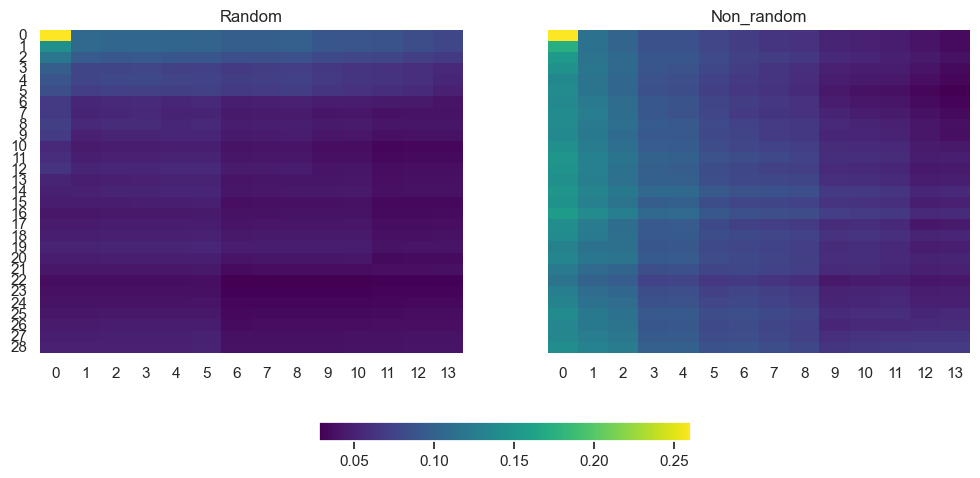

In [567]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

heatmap1 = sns.heatmap(matrix, cmap='viridis', ax=ax[0], cbar=False)
ax[0].set_title('Random')

heatmap2 = sns.heatmap(matrix2, cmap='viridis', ax=ax[1], cbar=False)
ax[1].set_title('Non_random')

# Add a shared colorbar to the plot
mappable = heatmap1.get_children()[0]
plt.colorbar(mappable, ax = ax,orientation = 'horizontal', shrink=0.4)

In [568]:
ratio_matrix = 1 - np.divide(matrix, matrix2)

<AxesSubplot: >

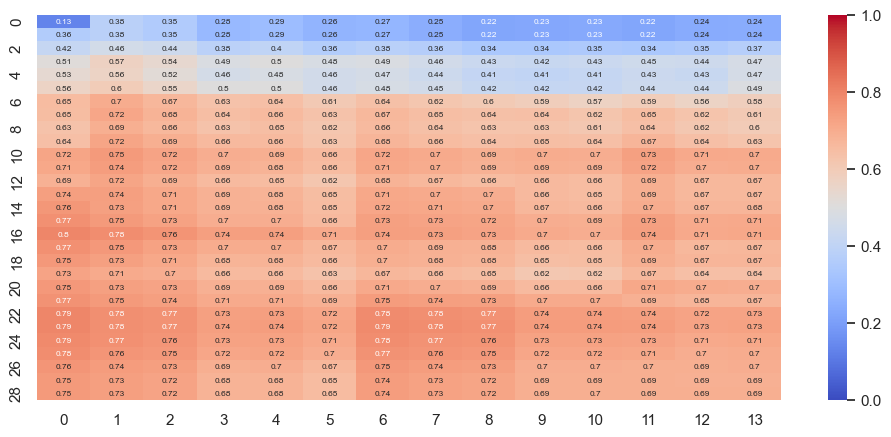

In [569]:
sns.heatmap(ratio_matrix, cmap='coolwarm', vmin=0, vmax=1, annot=True, annot_kws={'fontsize': 6})

#### GridSearch

In [579]:
# Define the ranges of parameter values to sample from
param_ranges = {
    'min_interval': np.arange(0, 14),
    'min_size': np.arange(1, 10),
    'min_vers_clean': np.linspace(0.5, 1, 10),
    'merge_noise': np.linspace(0, 0.2, 11)
}

# Set the number of random samples to generate
num_samples = 15000

# Initialize an empty dataframe to store the results
results_df = pd.DataFrame(columns=list(param_ranges.keys()) + ['random', 'non-random', 'difference', 'ratio'])

# Loop over all random samples of parameter values
for i in tqdm(range(num_samples)):
    # Sample random values for each parameter within the specified ranges
    param_values = {
        param_name: np.random.choice(param_range) for param_name, param_range in param_ranges.items()
    }
    
    # Apply the function to both dataframes with the current parameter values
    result1 = good_cookies_above_thresh(random_trial_data, **param_values)
    result2 = good_cookies_above_thresh(random_trial_data2, **param_values)
    
    # Compute the difference between the results
    difference = abs(result2 - result1)
    if result2 > 0:
        ratio = 1 - result1/result2
    else:
        ratio = 0.
    
    # Create a new dataframe with the current parameter values and the resulting difference
    row_df = pd.DataFrame({**param_values, 'random': result1, 'non-random': result2,
                           'difference': difference, 'ratio': ratio}, index=[0])
    
    # Concatenate the new dataframe to the results dataframe
    results_df = pd.concat([results_df, row_df], ignore_index=True)

  0%|          | 0/15000 [00:00<?, ?it/s]

In [580]:
results_df['min_interval'] = results_df['min_interval'].astype('int')
results_df['min_size'] = results_df['min_size'].astype('int')

In [581]:
results_df.sort_values(by='ratio', ascending=False).head(10)

,min_interval,min_size,min_vers_clean,merge_noise,random,non-random,difference,ratio
8195,1,8,1.000000,0.02,0.051724,0.188073,0.136349,0.724979
943,1,8,0.833333,0.02,0.051471,0.181637,0.130166,0.716629
13263,1,8,0.833333,0.02,0.051471,0.181637,0.130166,0.716629
2493,1,8,0.500000,0.02,0.051471,0.181275,0.129804,0.716063
1204,1,8,0.500000,0.02,0.051471,0.181275,0.129804,0.716063
13649,1,8,0.611111,0.02,0.051471,0.181275,0.129804,0.716063
11362,1,7,0.944444,0.02,0.051370,0.180608,0.129239,0.715573
210,1,7,0.944444,0.02,0.051370,0.180608,0.129239,0.715573
2610,1,7,0.944444,0.02,0.051370,0.180608,0.129239,0.715573
13151,1,8,0.888889,0.02,0.051661,0.180361,0.128700,0.713571


In [582]:
results_df.loc[results_df['ratio'] > 0.9].sort_values(by=['min_size', 'min_interval']).head()

,min_interval,min_size,min_vers_clean,merge_noise,random,non-random,difference,ratio


In [583]:
results_df[(results_df['min_size']<=7) 
           & (results_df['min_interval']<=7)].sort_values(by='ratio', ascending=False).head(10)

,min_interval,min_size,min_vers_clean,merge_noise,random,non-random,difference,ratio
11362,1,7,0.944444,0.02,0.051370,0.180608,0.129239,0.715573
2610,1,7,0.944444,0.02,0.051370,0.180608,0.129239,0.715573
210,1,7,0.944444,0.02,0.051370,0.180608,0.129239,0.715573
8903,1,7,0.777778,0.02,0.053512,0.179439,0.125928,0.701784
8487,1,7,0.777778,0.02,0.053512,0.179439,0.125928,0.701784
11584,1,7,0.777778,0.02,0.053512,0.179439,0.125928,0.701784
10026,1,7,0.777778,0.02,0.053512,0.179439,0.125928,0.701784
3529,1,7,1.000000,0.02,0.054688,0.183369,0.128681,0.701762
5895,1,7,1.000000,0.02,0.054688,0.183369,0.128681,0.701762
2877,1,7,1.000000,0.02,0.054688,0.183369,0.128681,0.701762


<AxesSubplot: xlabel='non-random', ylabel='ratio'>

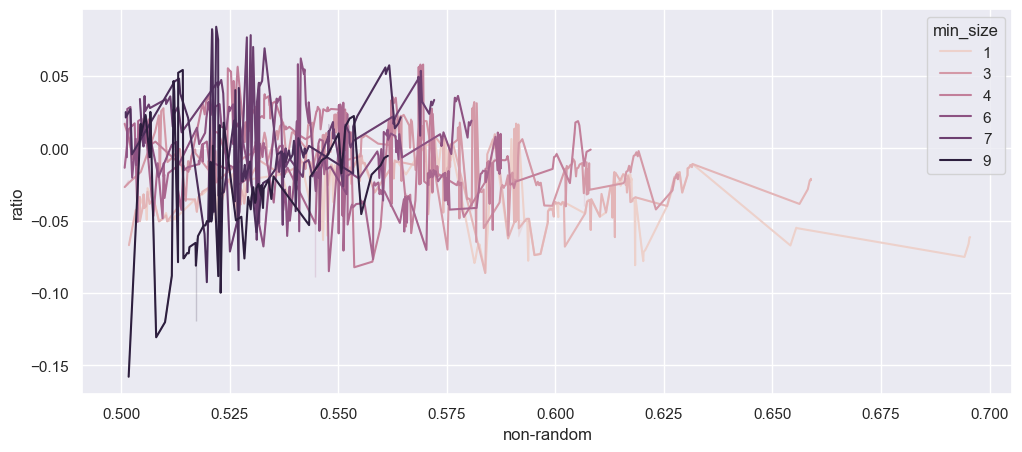

In [590]:
sns.lineplot(data=results_df.loc[results_df['non-random']>0.5], x='non-random', y='ratio', 
            hue='min_size')

In [585]:
cuts = results_df.copy()
cuts['non-random_cut'] = pd.cut(cuts.loc[cuts['non-random']>0.5, 'non-random'], 20)
cuts['nr_mid_cut'] = cuts['non-random_cut'].apply(lambda i:i.mid)

<AxesSubplot: xlabel='nr_mid_cut', ylabel='ratio'>

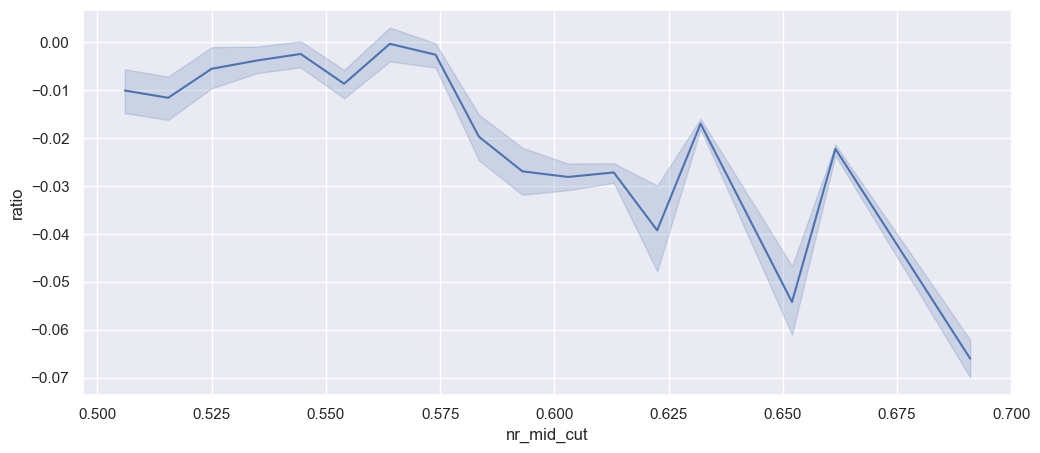

In [588]:
sns.lineplot(data=cuts, x='nr_mid_cut', y='ratio')#, hue='min_size')

<AxesSubplot: xlabel='min_size', ylabel='ratio'>

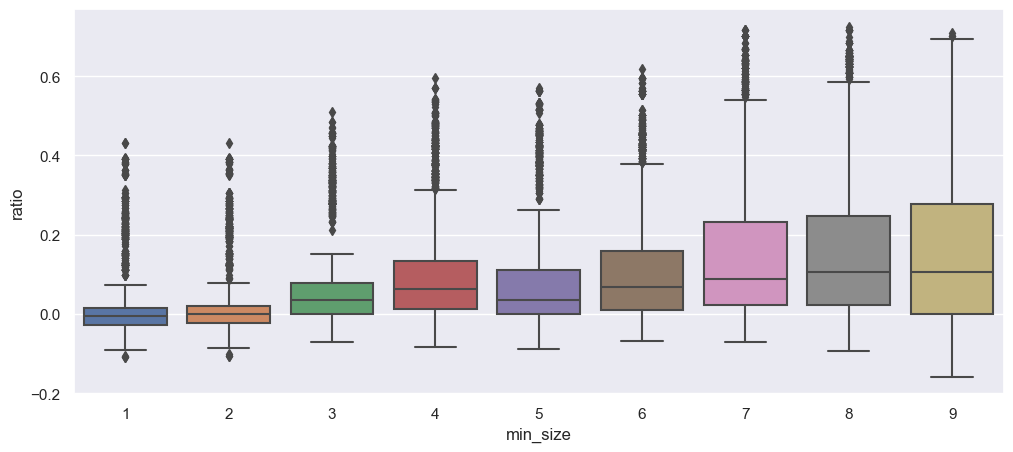

In [592]:
sns.boxplot(data=results_df, y='ratio', x='min_size')

## More features

- [X] Min interval
- [X] Max interval
- [X] Time between end first and start second (maybe after remove outliers)
- [ ] Time interval we looked at (can check options)
- [X] Min size
- [X] Max size
- [X] UA version error
- [X] Overlap errors that we calculate